In [1]:
import DirectDmTargets as dddm

calculating effective efficiency for Xe detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Ge detector done


In [2]:
import wimprates as wr

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



/data/xenon/joranang/anaconda/envs/dddm/lib/python3.7/site-packages/wimprates-0.3.0-py3.7.egg/wimprates/halo.py:129: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


Text(0.5, 0, 'v [km/s]')

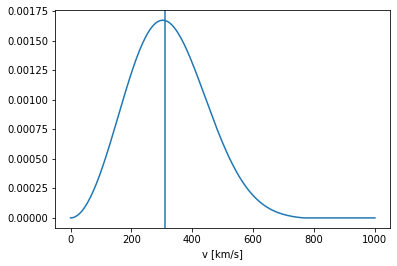

In [9]:
x = np.linspace(0,1000,200) * nu.km / nu.s
y2 = wr.observed_speed_dist(x, 0)
plt.plot(x/(nu.km / nu.s),y2)
plt.axvline(310)
plt.xlabel("v [km/s]")

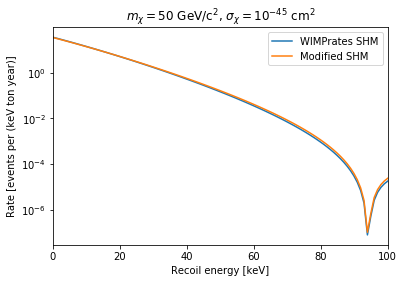

In [10]:
# NR's
energies = np.linspace(0.001, 100, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())

use_SHM = dddm.SHM()
dr_shm = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
plt.plot(energies, dr_shm, label = "Modified SHM")
plt.yscale('log')
plt.legend()

## Detector smearing

# Inference #
Below we setup the inference

In [11]:
# import emcee
# emcee.__version__

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [12]:
def get_gal_spec(det):

    spec_class = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors[det])
    spec_class.E_max = 200
    spec_class.mw = 50
    spec_class.n_bins = 200
    return spec_class.get_data(poisson = False)

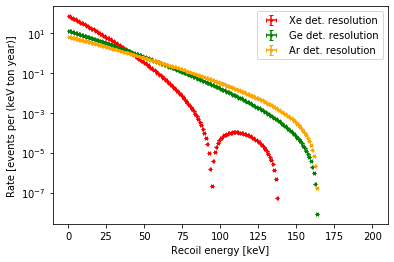

In [13]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
dddm.plot_spectrum(get_gal_spec('Xe'), 'red', label = 'Xe det. resolution', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ge'), 'green', label = 'Ge det. resolution', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ar'), 'orange', label = 'Ar det. resolution', plot_error = False)
plt.yscale("log")
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

In [14]:
def get_det_spec(det, mw =50):
    spec_class = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors[det])
    spec_class.E_max = 200
    spec_class.mw = mw
    spec_class.n_bins = 200
    return spec_class.get_data(poisson = False)

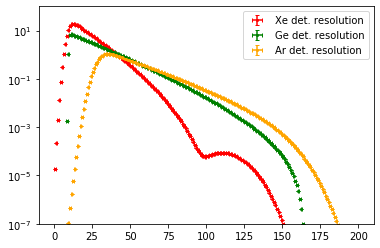

In [15]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
dddm.plot_spectrum(get_det_spec('Xe'), 'red', label = 'Xe det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ge'), 'green', label = 'Ge det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ar'), 'orange', label = 'Ar det. resolution', plot_error = False)
plt.yscale("log")
plt.ylim(1e-7,1e2)
plt.legend()

# Likelihood profiling

100%|██████████| 30/30 [00:00<00:00, 62.49it/s]
/data/xenon/joranang/software/DD_DM_targets/DirectDmTargets/plot_basics.py:104: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(var, plr, linestyle='steps-mid')


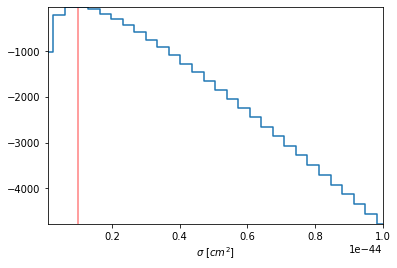

In [16]:
dddm.plt_ll_sigma_spec()

100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


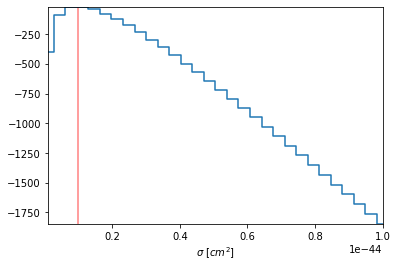

In [17]:
dddm.plt_ll_sigma_det()

100%|██████████| 100/100 [00:01<00:00, 76.14it/s]


(-1000, 0)

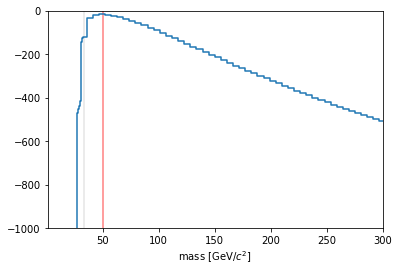

In [18]:
dddm.plt_ll_mass_spec()
plt.ylim(-1000,0)

100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


(-1000, 0)

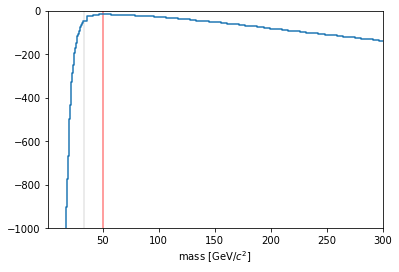

In [19]:
dddm.plt_ll_mass_det()
plt.ylim(-1000,0)

# Nested sampling

In [20]:
fit_class = dddm.NestleStatModel('Xe')
fit_class.tol = 0.8
fit_class.nlive = 2000
print(f"Fitting for parameters:\n{fit_class.fit_parameters}")

StatModel::	initialized for Xe detector. See print(stat_model) for default settings
Fitting for parameters:
['log_mass', 'log_cross_section']


In [21]:
fit_class.run_nestle()
fit_class.get_summary()

run_nestle::	start_fit for 2 parameters
run_nestle::	fit_done in 4291 s (1.2 h)
	 log_mass  1.71 +/-  0.04
	 mass 50.8 +/- 4.3
	 log_cross_section -45.00 +/-  0.03
	 cross_section 1e-45 +/- 5.8e-47


{'nestle_nposterior': 3097,
 'nestle_time': 4291,
 'nestle_logZ': -24.49734749422896,
 'nestle_logZerr': 0.05820926552217695,
 'summary': 'niter: 16473\nncall: 41190\nnsamples: 18473\nlogz: -24.497 +/-  0.058\nh:  6.777',
 'log_mass_fit_res': ' 1.71 +/-  0.04',
 'mass_fit_res': '50.8 +/- 4.3',
 'log_cross_section_fit_res': '-45.00 +/-  0.03',
 'cross_section_fit_res': '1e-45 +/- 5.8e-47'}

open_save_dir::	using results/nestle_17nov8/
	 log_mass  1.71 +/-  0.04
	 mass 50.8 +/- 4.3
	 log_cross_section -45.00 +/-  0.03
	 cross_section 1e-45 +/- 5.8e-47
save_results::	done_saving
load_nestle_samples::	loading results/nestle_17nov8/
load_nestle_samples::	done loading
access result with:
['config', 'res_dict', 'h', 'logl', 'logvol', 'logz', 'logzerr', 'ncall', 'niter', 'samples', 'weights']


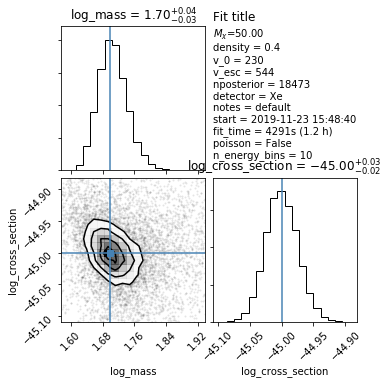

In [22]:
fit_class.show_corner()

In [23]:
fit_unconstrained = dddm.NestleStatModel('Xe')
fit_unconstrained.tol = 0.8
fit_unconstrained.nlive = 2000
fit_unconstrained.set_fit_parameters(fit_unconstrained.known_parameters)
print(f"Fitting for parameters:\n{fit_unconstrained.fit_parameters}")

StatModel::	initialized for Xe detector. See print(stat_model) for default settings
Fitting for parameters:
['log_mass', 'log_cross_section', 'v_0', 'v_esc', 'density']


In [24]:
fit_unconstrained.run_nestle()
fit_unconstrained.get_summary()

run_nestle::	start_fit for 5 parameters
run_nestle::	fit_done in 5382 s (1.5 h)
	 log_mass  1.71 +/-  0.06
	 mass 51.4 +/- 6.6
	 log_cross_section -44.99 +/-  0.10
	 cross_section 1.02e-45 +/- 2.4e-46
	 v_0 229.51 +/- 28.77
	 v_esc 544.52 +/- 32.49
	 density  0.41 +/-  0.09


{'nestle_nposterior': 3110,
 'nestle_time': 5382,
 'nestle_logZ': -24.437870423060147,
 'nestle_logZerr': 0.05805956685570225,
 'summary': 'niter: 16363\nncall: 42716\nnsamples: 18363\nlogz: -24.438 +/-  0.058\nh:  6.742',
 'log_mass_fit_res': ' 1.71 +/-  0.06',
 'mass_fit_res': '51.4 +/- 6.6',
 'log_cross_section_fit_res': '-44.99 +/-  0.10',
 'cross_section_fit_res': '1.02e-45 +/- 2.4e-46',
 'v_0_fit_res': '229.51 +/- 28.77',
 'v_esc_fit_res': '544.52 +/- 32.49',
 'density_fit_res': ' 0.41 +/-  0.09'}

open_save_dir::	using results/nestle_17nov9/
	 log_mass  1.71 +/-  0.06
	 mass 51.4 +/- 6.6
	 log_cross_section -44.99 +/-  0.10
	 cross_section 1.02e-45 +/- 2.4e-46
	 v_0 229.51 +/- 28.77
	 v_esc 544.52 +/- 32.49
	 density  0.41 +/-  0.09
save_results::	done_saving
load_nestle_samples::	loading results/nestle_17nov9/
load_nestle_samples::	done loading
access result with:
['config', 'res_dict', 'h', 'logl', 'logvol', 'logz', 'logzerr', 'ncall', 'niter', 'samples', 'weights']


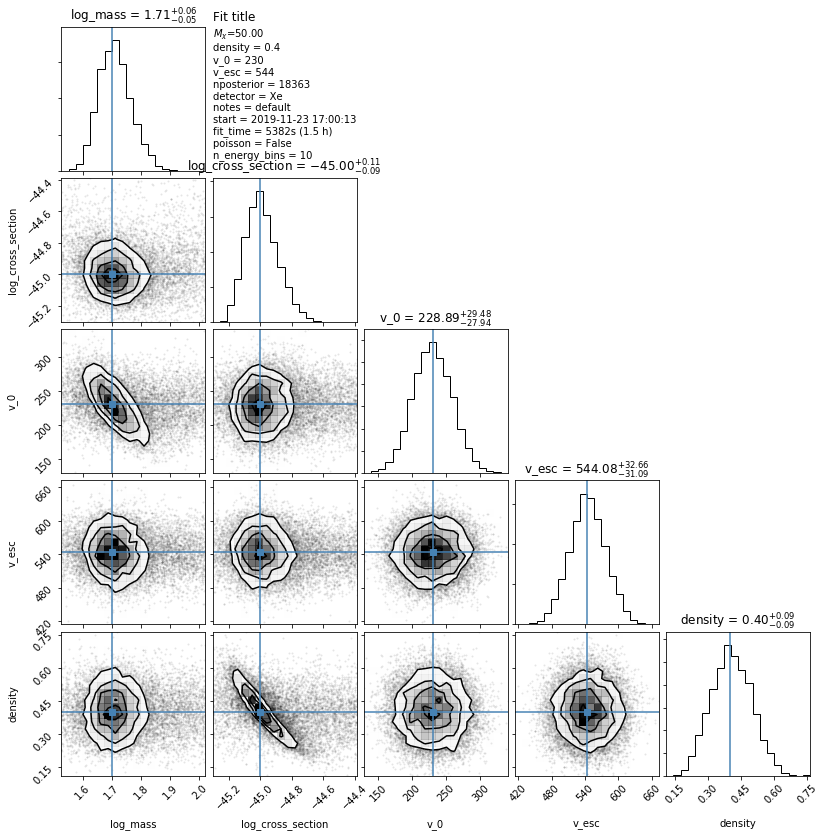

In [25]:
fit_unconstrained.show_corner()